In [58]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy
import time
import plotly.express as px
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import KFold
from sklearn import preprocessing
from sklearn import decomposition
import sys
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

# Modele
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor



result = pd.read_csv('seattle_clean')

## Récap info de nos données

In [59]:
result.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3307 entries, 0 to 3306
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   OSEBuildingID           3307 non-null   int64  
 1   BuildingType            3307 non-null   object 
 2   PrimaryPropertyType     3307 non-null   object 
 3   PropertyName            3307 non-null   object 
 4   Neighborhood            3307 non-null   object 
 5   NumberofBuildings       3307 non-null   float64
 6   NumberofFloors          3307 non-null   float64
 7   PropertyGFATotal        3307 non-null   int64  
 8   LargestPropertyUseType  3307 non-null   object 
 9   ENERGYSTARScore         2209 non-null   float64
 10  SiteEnergyUseWN(kBtu)   3307 non-null   float64
 11  SteamUse(kBtu)          3307 non-null   float64
 12  Electricity(kBtu)       3307 non-null   float64
 13  NaturalGas(kBtu)        3307 non-null   float64
 14  TotalGHGEmissions       3307 non-null   

Le but de notre programme est de supprimer les relevés couteux pour les années à venir. Nous allons donc exclure toutes les données de relève de notre dataset.

In [60]:
result = result.drop(columns={'SteamUse(kBtu)',
                              'Electricity(kBtu)',
                              'NaturalGas(kBtu)'})

## Selection des variables numériques et catégorielles

In [61]:
variables_cat = result.select_dtypes(exclude=['int64','float64'])
variables_num = result.select_dtypes(include=['int64','float64'])


In [62]:
variables_cat.nunique()

BuildingType                 5
PrimaryPropertyType         24
PropertyName              3194
Neighborhood                14
LargestPropertyUseType      58
dtype: int64

Sur ces variables de catégorie, le nom du batiment ne sera d'aucune utilité

In [63]:
result = result.drop(columns={'PropertyName'})

In [64]:
variables_num.nunique()

OSEBuildingID            1697
NumberofBuildings          17
NumberofFloors             44
PropertyGFATotal         1666
ENERGYSTARScore           100
SiteEnergyUseWN(kBtu)    3271
TotalGHGEmissions        3012
BuildingAge               115
Nombre_utilisation         11
Taux_Building             380
Taux_Parking              380
surface_batiment         1714
surface_etage            1705
dtype: int64

il peut être interessant de savoir si le EnergyStarScore a une influence sur les emission et l'energy utilisés. Je garde ces données, mais je les mets de coté pour ne pas influencer les predictions

In [65]:
result_EnergyStar = result['ENERGYSTARScore']
result_num = result.drop(columns={'ENERGYSTARScore'})

## Encoder pour les variables catégorielles

In [66]:
result_Encoder = result_num[['BuildingType', 'Neighborhood', 'PrimaryPropertyType']]
lb = OneHotEncoder()
one_hot = lb.fit_transform(result_Encoder)# pour les Types de batiments
lb.get_feature_names(['BuildingType', 'Neighborhood', 'PrimaryPropertyType'])
one_hot = one_hot.toarray()
one_hot = pd.DataFrame(one_hot, columns=lb.get_feature_names(['BuildingType', 'Neighborhood', 'PrimaryPropertyType']))

In [67]:
result_num =  pd.concat([result_num, one_hot], axis=1)

In [68]:
result_num

,OSEBuildingID,BuildingType,PrimaryPropertyType,Neighborhood,NumberofBuildings,NumberofFloors,PropertyGFATotal,LargestPropertyUseType,SiteEnergyUseWN(kBtu),TotalGHGEmissions,...,PrimaryPropertyType_Residence Hall,PrimaryPropertyType_Residence Hall/Dormitory,PrimaryPropertyType_Restaurant,PrimaryPropertyType_Retail Store,PrimaryPropertyType_Self-Storage Facility,PrimaryPropertyType_Senior Care Community,PrimaryPropertyType_Small- and Mid-Sized Office,PrimaryPropertyType_Supermarket/Grocery Store,PrimaryPropertyType_Warehouse,PrimaryPropertyType_Worship Facility
0,1,NonResidential,Hotel,DOWNTOWN,1.0,12.0,88434,Hotel,7.097539e+06,249.43,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,NonResidential,Hotel,DOWNTOWN,1.0,11.0,103566,Hotel,8.765788e+06,263.51,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,NonResidential,Hotel,DOWNTOWN,1.0,41.0,961990,Hotel,7.550627e+07,2061.48,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,5,NonResidential,Hotel,DOWNTOWN,1.0,10.0,61320,Hotel,2.836344e+07,1936.34,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,8,NonResidential,Hotel,DOWNTOWN,1.0,18.0,119890,Hotel,1.507824e+07,507.70,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3302,50222,Nonresidential COS,Office,GREATER DUWAMISH,1.0,1.0,12294,Office,9.430032e+05,20.94,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3303,50223,Nonresidential COS,Other,DOWNTOWN,1.0,1.0,16000,Other - Recreation,1.053706e+06,32.17,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3304,50224,Nonresidential COS,Other,MAGNOLIA / QUEEN ANNE,1.0,1.0,13157,Other - Recreation,6.053764e+06,223.54,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3305,50225,Nonresidential COS,Mixed Use Property,GREATER DUWAMISH,1.0,1.0,14101,Other - Recreation,7.828413e+05,22.11,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [69]:
result_num = result_num.drop(columns={'BuildingType',
                                      'PrimaryPropertyType',
                                      'Neighborhood',
                                      'LargestPropertyUseType'})
result_num

,OSEBuildingID,NumberofBuildings,NumberofFloors,PropertyGFATotal,SiteEnergyUseWN(kBtu),TotalGHGEmissions,BuildingAge,Nombre_utilisation,Taux_Building,Taux_Parking,...,PrimaryPropertyType_Residence Hall,PrimaryPropertyType_Residence Hall/Dormitory,PrimaryPropertyType_Restaurant,PrimaryPropertyType_Retail Store,PrimaryPropertyType_Self-Storage Facility,PrimaryPropertyType_Senior Care Community,PrimaryPropertyType_Small- and Mid-Sized Office,PrimaryPropertyType_Supermarket/Grocery Store,PrimaryPropertyType_Warehouse,PrimaryPropertyType_Worship Facility
0,1,1.0,12.0,88434,7.097539e+06,249.43,88,1,1.00000,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,1.0,11.0,103566,8.765788e+06,263.51,19,3,0.85455,0.14545,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,1.0,41.0,961990,7.550627e+07,2061.48,46,3,1.00000,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,5,1.0,10.0,61320,2.836344e+07,1936.34,89,1,1.00000,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,8,1.0,18.0,119890,1.507824e+07,507.70,35,3,0.89607,0.10393,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3302,50222,1.0,1.0,12294,9.430032e+05,20.94,26,1,1.00000,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3303,50223,1.0,1.0,16000,1.053706e+06,32.17,12,1,1.00000,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3304,50224,1.0,1.0,13157,6.053764e+06,223.54,42,3,1.00000,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3305,50225,1.0,1.0,14101,7.828413e+05,22.11,27,5,1.00000,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Standardisation des données

In [70]:
X = result_num.values

from sklearn.preprocessing import RobustScaler

X_robust = RobustScaler().fit_transform(X)

resultNorm = pd.DataFrame(X_robust, columns = result_num.columns)
resultNorm

,OSEBuildingID,NumberofBuildings,NumberofFloors,PropertyGFATotal,SiteEnergyUseWN(kBtu),TotalGHGEmissions,BuildingAge,Nombre_utilisation,Taux_Building,Taux_Parking,...,PrimaryPropertyType_Residence Hall,PrimaryPropertyType_Residence Hall/Dormitory,PrimaryPropertyType_Restaurant,PrimaryPropertyType_Retail Store,PrimaryPropertyType_Self-Storage Facility,PrimaryPropertyType_Senior Care Community,PrimaryPropertyType_Small- and Mid-Sized Office,PrimaryPropertyType_Supermarket/Grocery Store,PrimaryPropertyType_Warehouse,PrimaryPropertyType_Worship Facility
0,-0.881055,0.0,3.333333,0.520143,0.754022,1.680258,0.644068,-1.0,0.00000,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-0.881013,0.0,3.000000,0.721006,1.039333,1.798389,-0.525424,1.0,-0.14545,0.14545,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-0.880971,0.0,13.000000,12.115763,12.453566,16.883296,-0.067797,1.0,0.00000,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-0.880888,0.0,2.666667,0.160231,4.391005,15.833375,0.661017,-1.0,0.00000,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-0.880763,0.0,5.333333,0.937692,2.118915,3.847135,-0.254237,1.0,-0.10393,0.10393,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3302,1.214193,0.0,-0.333333,-0.490542,-0.298552,-0.236765,-0.406780,-1.0,0.00000,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3303,1.214235,0.0,-0.333333,-0.441349,-0.279619,-0.142546,-0.644068,-1.0,0.00000,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3304,1.214277,0.0,-0.333333,-0.479087,0.575511,1.463042,-0.135593,1.0,0.00000,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3305,1.214318,0.0,-0.333333,-0.466556,-0.325944,-0.226949,-0.389831,3.0,0.00000,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Séparation du jeu de données

Afin de tester notre meilleur modèle sur des données "inconnues", nous allons mettre de côté une partie des données initiales qui ne seront pas inclusent dans les modèles intermédiaires. Nous allons donc spliter nos données pour obtenir un jeu d'entrainement et un jeu de test

In [71]:
X = resultNorm.drop(['TotalGHGEmissions','SiteEnergyUseWN(kBtu)', 'OSEBuildingID'], axis=1)
Y = resultNorm[['TotalGHGEmissions', 'SiteEnergyUseWN(kBtu)']]

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=5)

print("Entrainement: {} lignes,\nTest: {} lignes.\n".format(X_train.shape[0],
                                                            X_test.shape[0]))

Entrainement: 2645 lignes,
Test: 662 lignes.



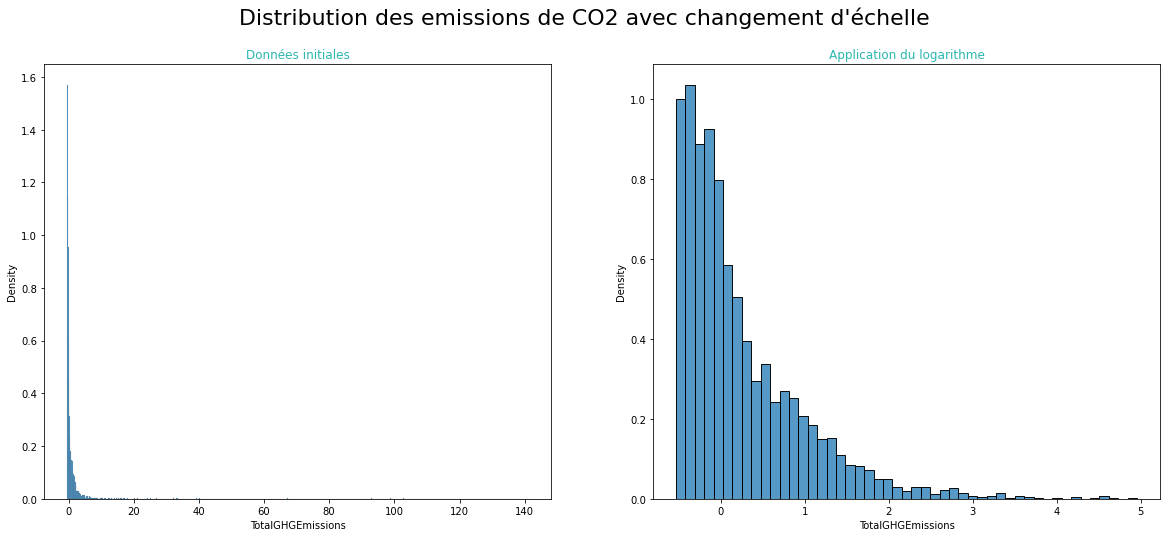

In [72]:
from sklearn.preprocessing import FunctionTransformer

logtransformer = FunctionTransformer(func=(lambda x : np.log(1+x)), inverse_func = (lambda x : np.exp(x)-1), check_inverse = True)
Y_log = logtransformer.transform(Y)

fig, axes = plt.subplots(nrows=1, ncols=2, sharex=False, figsize=(20,8))
sns.histplot(data=Y, x='TotalGHGEmissions', stat="density", ax=axes[0])
axes[0].set_title("Données initiales", color='#2cb7b0')
sns.histplot(data=Y_log, x='TotalGHGEmissions', stat="density", ax=axes[1])
axes[1].set_title("Application du logarithme", color='#2cb7b0')
plt.suptitle("Distribution des emissions de CO2 avec changement d'échelle", fontsize=22)
plt.show()

In [73]:
# Distribution des indices train/validation pour obtenir des jeux train/validation.
# Divise le jeu de données en k partitions

kf = KFold(5)

## Regression Lineaire

In [74]:
from sklearn.pipeline import Pipeline
from sklearn import set_config
set_config(display='diagram')


param_mlr = {"fit_intercept": [True, False],
             "normalize": [True, False]}

mlr_grid_cv = Pipeline([
       ('grid_search_mlr', GridSearchCV(
                            LinearRegression(),
                            param_grid=param_mlr,
                            cv=kf,
                            scoring=('r2','neg_mean_absolute_error'),
                            return_train_score = True,
                            refit='neg_mean_absolute_error',
                            n_jobs = -1))])

In [75]:
def model_scores(pip,step):
    df_results = pd.DataFrame.from_dict(pip.named_steps[step].cv_results_) \
                    .sort_values('rank_test_neg_mean_absolute_error')
    best_nmae = pip.named_steps[step].best_score_
    best_r2 = np.mean(df_results[df_results.rank_test_r2 == 1]['mean_test_r2'])
    best_params = pip.named_steps[step].best_params_
    training_time = round((np.mean(df_results.mean_fit_time)*X_train.shape[0]),2)
    print("Meilleur score MAE : {}\nMeilleur Score R2 : {}\nMeilleurs paramètres : {}\nTemps moyen d'entrainement : {}s"\
         .format(round(best_nmae,3), round(best_r2,3), best_params, training_time))
    return df_results

### Résultat TotalGHGEmissions pour Regression Linéaire

In [76]:
#Entrainement sur les 2 variables à expliquer :
TotEmis_mlr_model = mlr_grid_cv.fit(X_train, Y_train['TotalGHGEmissions'])
TotEmis_mlr_results = model_scores(TotEmis_mlr_model, 'grid_search_mlr')

Meilleur score MAE : -464391.141
Meilleur Score R2 : -39237276248851.57
Meilleurs paramètres : {'fit_intercept': False, 'normalize': True}
Temps moyen d'entrainement : 67.72s


### Résultat SiteEnergyUseWN(kBtu) pour Regression Linéaire

In [77]:
SEU_mlr_model = mlr_grid_cv.fit(X_train, Y_train['SiteEnergyUseWN(kBtu)'])
SEU_mlr_results = model_scores(SEU_mlr_model, 'grid_search_mlr')

Meilleur score MAE : -9457781.829
Meilleur Score R2 : -3.1040076198904692e+16
Meilleurs paramètres : {'fit_intercept': False, 'normalize': True}
Temps moyen d'entrainement : 30.69s


## ElasticNet

In [78]:
param_eNet = {"max_iter": [10, 100, 1000],
              "alpha": np.logspace(-4, 0, num=5),
              "l1_ratio": np.arange(0.0, 1.1, 0.1)}

eNet_grid_cv = Pipeline([
    ('grid_search_enet', GridSearchCV(
                            ElasticNet(), 
                            param_grid=param_eNet,
                            cv=kf,
                            scoring=('r2','neg_mean_absolute_error'),
                            return_train_score = True,
                            refit='neg_mean_absolute_error',
                            n_jobs = -1))])

### Résultat TotalGHGEmissions pour ElasticNet

In [79]:
TotEmis_eNet_model = eNet_grid_cv.fit(X_train, Y_train['TotalGHGEmissions'])
TotEmis_eNet_results = model_scores(TotEmis_eNet_model, 'grid_search_enet')

Meilleur score MAE : -1.066
Meilleur Score R2 : 0.423
Meilleurs paramètres : {'alpha': 0.01, 'l1_ratio': 1.0, 'max_iter': 10}
Temps moyen d'entrainement : 111.69s


### Résultat SiteEnergyUseWN(kBtu) pour ElasticNet

In [80]:
SEU_eNet_model = eNet_grid_cv.fit(X_train, Y_train['SiteEnergyUseWN(kBtu)'])
SEU_eNet_results = model_scores(SEU_eNet_model, 'grid_search_enet')

Meilleur score MAE : -0.705
Meilleur Score R2 : 0.515
Meilleurs paramètres : {'alpha': 0.01, 'l1_ratio': 1.0, 'max_iter': 10}
Temps moyen d'entrainement : 96.97s


## KNeighbors

In [81]:
param_KNN = {'n_neighbors' : np.arange(1,20),
             'weights' : ['uniform', 'distance']}

KNN_grid_cv = Pipeline([
    ('grid_search_KNN', GridSearchCV(
                            KNeighborsRegressor(), 
                            param_grid=param_KNN,
                            cv=kf,
                            scoring=('r2','neg_mean_absolute_error'),
                            return_train_score = True,
                            refit='neg_mean_absolute_error',
                            n_jobs = -1))])

### Résultat TotalGHGEmissions pour KNN

In [82]:
TotEmis_KNN_model = KNN_grid_cv.fit(X_train, Y_train['TotalGHGEmissions'])
TotEmis_KNN_results = model_scores(TotEmis_KNN_model, 'grid_search_KNN')

Meilleur score MAE : -0.713
Meilleur Score R2 : 0.362
Meilleurs paramètres : {'n_neighbors': 5, 'weights': 'distance'}
Temps moyen d'entrainement : 45.24s


### Résultat SiteEnergyUseWN(kBtu) pour KNN

In [83]:
SEU_KNN_model = KNN_grid_cv.fit(X_train, Y_train['SiteEnergyUseWN(kBtu)'])
SEU_KNN_results = model_scores(SEU_KNN_model, 'grid_search_KNN')

Meilleur score MAE : -0.502
Meilleur Score R2 : 0.483
Meilleurs paramètres : {'n_neighbors': 8, 'weights': 'distance'}
Temps moyen d'entrainement : 41.74s


## Random Forest


Un random forest est constitué d'un ensemble d'arbres de décision indépendants. 

Chaque arbre dispose d'une vision parcellaire du problème du fait d'un double tirage aléatoire :

   - un tirage aléatoire avec remplacement sur les observations (les lignes de votre base de données). Ce processus s'appelle le tree bagging,
   - un tirage aléatoire sur les variables (les colonnes de votre base de données). Ce processus s'appelle le feature sampling.

A la fin, tous ces arbres de décisions indépendants sont assemblés. La prédiction faite par le random forest pour des données inconnues est alors la moyenne de tous les arbres.

In [84]:
param_rfr = {'max_features' : ['sqrt', 'log2'],
             'max_depth': [15, 25, 50, 100], # Nombre de profondeurs maximums
             'min_samples_split': [2, 5, 10],
             'bootstrap' : [True, False],
             'min_samples_leaf': [1,2,5,10]}

rfr_grid_cv = Pipeline([
    ('grid_search_rfr', GridSearchCV(
                            RandomForestRegressor(), 
                            param_grid=param_rfr,
                            cv=kf,
                            scoring=('r2','neg_mean_absolute_error'),
                            refit='neg_mean_absolute_error',
                            return_train_score = True,
                            n_jobs = -1))])

### Résultat TotalGHGEmissions pour Random Forest

In [85]:
TotEmis_rfr_model = rfr_grid_cv.fit(X_train, Y_train['TotalGHGEmissions'])
TotEmis_rfr_results = model_scores(TotEmis_rfr_model, 'grid_search_rfr')

Meilleur score MAE : -0.61
Meilleur Score R2 : 0.534
Meilleurs paramètres : {'bootstrap': False, 'max_depth': 25, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2}
Temps moyen d'entrainement : 1371.66s


### Résultat SiteEnergyUseWN(kBtu) pour Random Forest

In [86]:
SEU_rfr_model = rfr_grid_cv.fit(X_train, Y_train['SiteEnergyUseWN(kBtu)'])
SEU_rfr_results = model_scores(SEU_rfr_model, 'grid_search_rfr')

Meilleur score MAE : -0.441
Meilleur Score R2 : 0.572
Meilleurs paramètres : {'bootstrap': False, 'max_depth': 50, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2}
Temps moyen d'entrainement : 1384.9s


## Réseau de neurones

In [30]:
param_neurone = {'hidden_layer_sizes': [1,50,100, 200],
                 'alpha': [0.00005,0.0005],
                 'activation': ["identity", "logistic", "tanh", "relu"], 
                 'solver': ["lbfgs", "sgd", "adam"]}

MLP_grid_cv = Pipeline([
    ('grid_search_MLP', GridSearchCV(
                            MLPRegressor(), 
                            param_grid=param_neurone,
                            cv=kf,
                            scoring=('r2','neg_mean_absolute_error'),
                            refit='neg_mean_absolute_error',
                            return_train_score = True,
                            n_jobs = -1))])

### Résultat TotalGHGEmissions pour MLPRegressor

In [31]:
TotEmis_MLP_model = MLP_grid_cv.fit(X_train, Y_train['TotalGHGEmissions'])
TotEmis_MLP_results = model_scores(TotEmis_MLP_model, 'grid_search_MLP')

Meilleur score MAE : -1.006
Meilleur Score R2 : 0.496
Meilleurs paramètres : {'activation': 'tanh', 'alpha': 0.0005, 'hidden_layer_sizes': 1, 'solver': 'adam'}
Temps moyen d'entrainement : 16056.73s


### Résultat SiteEnergyUseWN(kBtu) pour MLPRegressor

In [32]:
SEU_MLP_model = rfr_grid_cv.fit(X_train, Y_train['SiteEnergyUseWN(kBtu)'])
SEU_MLP_results = model_scores(SEU_MLP_model, 'grid_search_rfr')

Meilleur score MAE : -0.447
Meilleur Score R2 : 0.57
Meilleurs paramètres : {'bootstrap': False, 'max_depth': 100, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2}
Temps moyen d'entrainement : 1488.32s


## Selection du meilleur modéle

### Total Emission CO2

In [33]:
metric = ['mean_fit_time', 'mean_score_time',
           'mean_test_neg_mean_absolute_error',
           'mean_train_neg_mean_absolute_error']
TotEmis_metric = pd.concat([pd.DataFrame(TotEmis_mlr_results[metric].mean(), columns=['LinearRegression']),
           pd.DataFrame(TotEmis_eNet_results[metric].mean(), columns=['ElasticNet']),
           pd.DataFrame(TotEmis_KNN_results[metric].mean(), columns=['KNeighbors']),
           pd.DataFrame(TotEmis_rfr_results[metric].mean(), columns=['RandomForest']),
           pd.DataFrame(TotEmis_MLP_results[metric].mean(), columns=['MLPRegressor'])
          ], axis=1)
TotEmis_compare = pd.DataFrame(columns=metric, 
                                     index=['LinearRegression','ElasticNet',
                                            'KNeighbors','RandomForest',
                                            'MLPRegressor'])
for c in metric:
    TotEmis_compare[c] = TotEmis_metric.loc[c]

In [34]:
TotEmis_compare

,mean_fit_time,mean_score_time,mean_test_neg_mean_absolute_error,mean_train_neg_mean_absolute_error
LinearRegression,0.024105,0.005717,-6.658908e+10,-1.112082
ElasticNet,0.034057,0.004938,-1.155758e+00,-1.129696
KNeighbors,0.015736,0.156408,-8.445742e-01,-0.394798
RandomForest,0.490986,0.026130,-8.991145e-01,-0.682112
MLPRegressor,6.070596,0.010008,-1.156674e+00,-0.961845


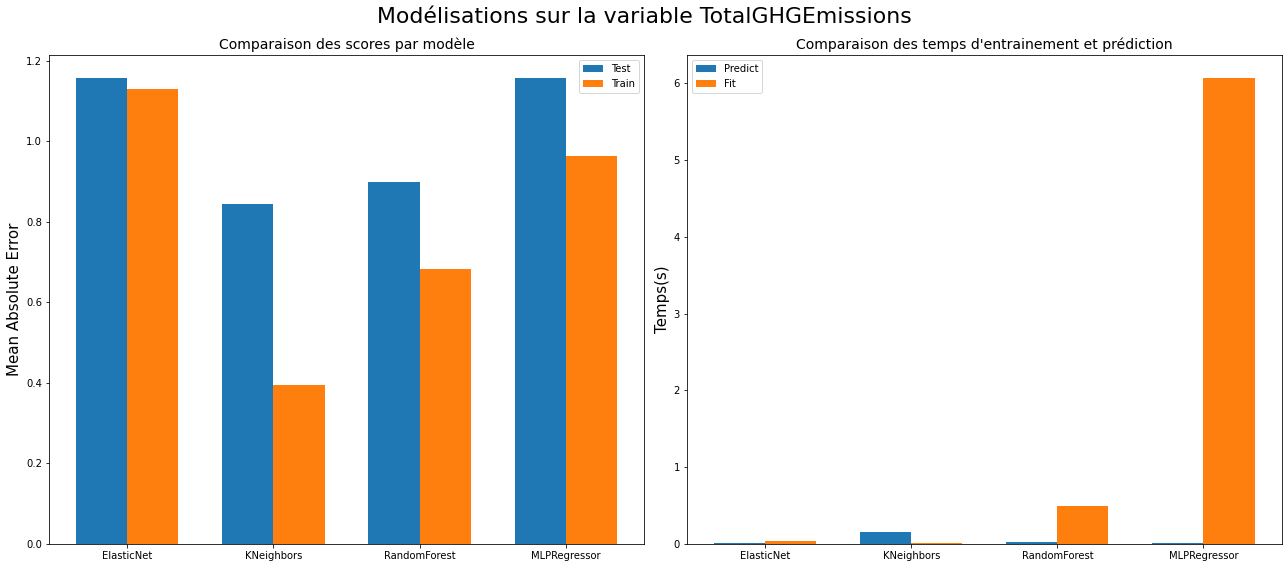

In [35]:
#On élimine le modèle regression lineaire de cette représentation car hors normes
TotEmis_compare = TotEmis_compare[TotEmis_compare.index != 'LinearRegression']
x = np.arange(len(TotEmis_compare.index))
width = 0.35

fig, ax = plt.subplots(1,2,figsize=(18,8), sharey=False, sharex=False)

scores1 = ax[0].bar(x - width/2, -1*TotEmis_compare['mean_test_neg_mean_absolute_error'], width, label='Test')
scores2 = ax[0].bar(x + width/2, -1*TotEmis_compare['mean_train_neg_mean_absolute_error'], width, label='Train')
ax[0].set_ylabel('Mean Absolute Error', fontsize = 15)
ax[0].set_title('Comparaison des scores par modèle', fontsize = 14)
ax[0].set_xticks(x)
ax[0].set_xticklabels(TotEmis_compare.index)
ax[0].legend()

times1 = ax[1].bar(x - width/2, TotEmis_compare['mean_score_time'], width, label='Predict')
times2 = ax[1].bar(x + width/2, TotEmis_compare['mean_fit_time'], width, label='Fit')
ax[1].set_ylabel('Temps(s)', fontsize = 15)
ax[1].set_title('Comparaison des temps d\'entrainement et prédiction', fontsize = 14)
ax[1].set_xticks(x)
ax[1].set_xticklabels(TotEmis_compare.index)
ax[1].legend()

plt.suptitle('Modélisations sur la variable TotalGHGEmissions', fontsize=22)
fig.tight_layout()

plt.show()

Le modèle retenu pour les prédictions des Emissions de CO2 est le RandomForest, la MAE est quasiment egal au KNN mais sont R² est meilleur.

### Site Energy Use

In [36]:
metric = ['mean_fit_time', 'mean_score_time',
           'mean_test_neg_mean_absolute_error',
           'mean_train_neg_mean_absolute_error']
SEU_metric = pd.concat([pd.DataFrame(SEU_mlr_results[metric].mean(), columns=['LinearRegression']),
           pd.DataFrame(SEU_eNet_results[metric].mean(), columns=['ElasticNet']),
           pd.DataFrame(SEU_KNN_results[metric].mean(), columns=['KNeighbors']),
           pd.DataFrame(SEU_rfr_results[metric].mean(), columns=['RandomForest']),
           pd.DataFrame(SEU_MLP_results[metric].mean(), columns=['MLPRegressor'])
          ], axis=1)
SEU_compare = pd.DataFrame(columns=metric, 
                                     index=['LinearRegression','ElasticNet',
                                            'KNeighbors','RandomForest',
                                            'MLPRegressor'])
for c in metric:
    SEU_compare[c] = SEU_metric.loc[c]

In [37]:
SEU_compare

,mean_fit_time,mean_score_time,mean_test_neg_mean_absolute_error,mean_train_neg_mean_absolute_error
LinearRegression,0.009374,0.002344,-4.626609e+10,-0.726801
ElasticNet,0.031271,0.004232,-7.585459e-01,-0.745411
KNeighbors,0.019854,0.196383,-5.901298e-01,-0.274002
RandomForest,0.500194,0.026189,-6.287675e-01,-0.470221
MLPRegressor,0.562690,0.029969,-6.284675e-01,-0.469901


Tout comme pour les emissions de CO2, nous eliminons lq regression lineaire qui a une MAE sur le jeu de Test vraimant hors norme

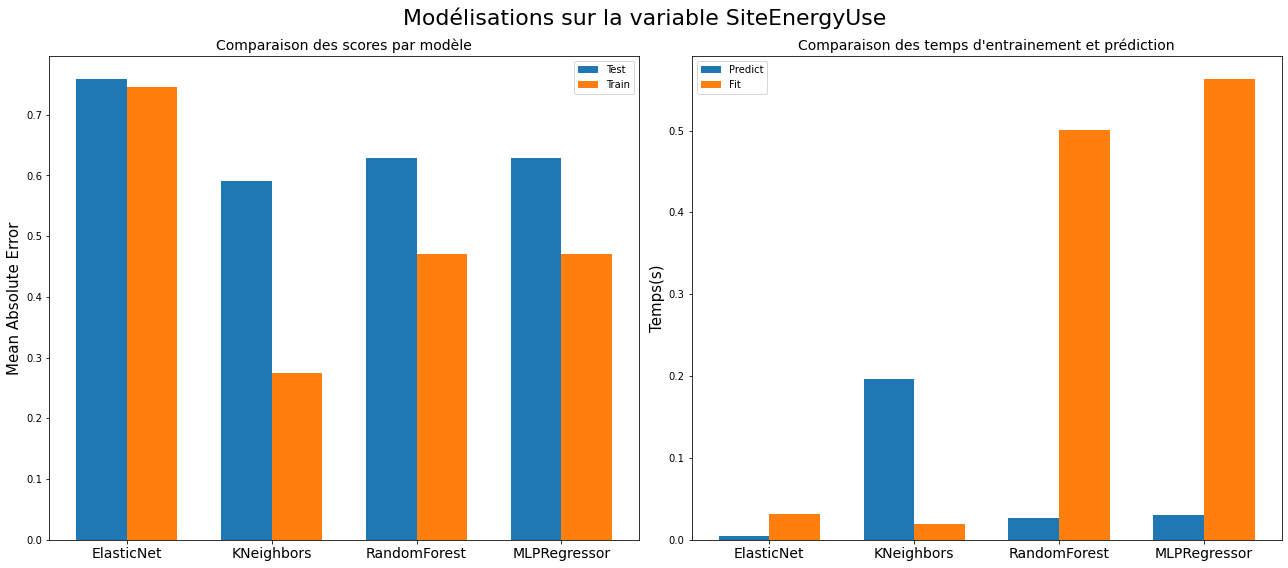

In [38]:
#On élimine le modèle regression lineaire de cette représentation car hors normes
SEU_compare = SEU_compare[SEU_compare.index != 'LinearRegression']
x = np.arange(len(SEU_compare.index))
width = 0.35

fig, ax = plt.subplots(1,2,figsize=(18,8), sharey=False, sharex=False)

scores1 = ax[0].bar(x - width/2, -1*SEU_compare['mean_test_neg_mean_absolute_error'], width, label='Test')
scores2 = ax[0].bar(x + width/2, -1*SEU_compare['mean_train_neg_mean_absolute_error'], width, label='Train')
ax[0].set_ylabel('Mean Absolute Error', fontsize = 15)
ax[0].set_title('Comparaison des scores par modèle', fontsize = 14)
ax[0].set_xticks(x)
ax[0].set_xticklabels(SEU_compare.index, fontsize=14)
ax[0].legend()

times1 = ax[1].bar(x - width/2, SEU_compare['mean_score_time'], width, label='Predict')
times2 = ax[1].bar(x + width/2, SEU_compare['mean_fit_time'], width, label='Fit')
ax[1].set_ylabel('Temps(s)', fontsize = 15)
ax[1].set_title('Comparaison des temps d\'entrainement et prédiction', fontsize = 14)
ax[1].set_xticks(x)
ax[1].set_xticklabels(SEU_compare.index, fontsize=14)
ax[1].legend()

plt.suptitle('Modélisations sur la variable SiteEnergyUse', fontsize=22)
fig.tight_layout()

plt.show()

Tout comme les emissions, le modele qui conviendrai le mieux pour l'energie utilisé est le RandomForest

## Final TotalGHGEmissions

In [87]:
def metrics_model(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    diff = y_true - y_pred
    mae = np.mean(abs(diff))
    r2 = 1-(sum(diff**2)/sum((y_true-np.mean(y_true))**2))
    dict_metrics = {"Métrique":["MAE", "R²"], "Résultats":[mae, r2]}
    df_metrics = pd.DataFrame(dict_metrics)
    return df_metrics

In [88]:
def plot_pred_true(y_true, y_pred, color=None, title=None):
    X_plot = [y_true.min(), y_true.max()]
    fig = plt.figure(figsize=(12,8))
    plt.scatter(y_true, y_pred, color=color, alpha=.6)
    plt.plot(X_plot, X_plot, color='r')
    plt.xlabel("Valeurs réélles")
    plt.ylabel("Valeurs prédites")
    plt.title("Valeurs prédites VS valeurs réélles | Variable {}".format(title), fontsize=18)
    plt.show()

In [89]:
import time
start_time = time.time()

Emissions_pred = TotEmis_rfr_model.predict(X_test)

print("Temps d'execution de l'agorithme : {:.2} s.".format((time.time() - start_time)))

Temps d'execution de l'agorithme : 0.014 s.


In [90]:
#Calcul des métriques pour les émissions de CO2
GHGmetrics = metrics_model(Y_test['TotalGHGEmissions'],Emissions_pred)
GHGmetrics

,Métrique,Résultats
0,MAE,1.272185
1,R²,0.489218


Les métriques sur le jeu de données de test se sont un peu dégradées par rapport a ceux obtenues avec le modèle RandomForest.

### Vérification des valeurs prédites et réelles

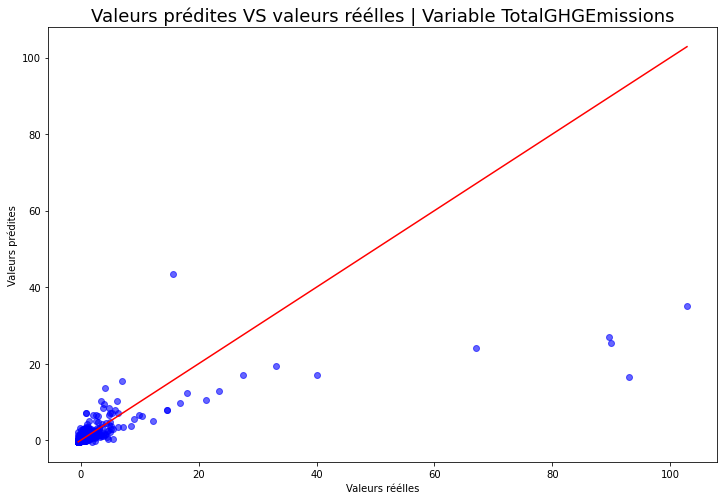

In [91]:
#Affichage des valeurs prédites vs valeurs réélles pour émissions de CO2
plot_pred_true(Y_test['TotalGHGEmissions'],Emissions_pred, color="blue", title="TotalGHGEmissions")

Les valeurs prédites sont très éloignées de la première bissectrice

In [92]:
Emissions_test_results = TotEmis_rfr_results[['split0_test_neg_mean_absolute_error',
                'split1_test_neg_mean_absolute_error',
                'split2_test_neg_mean_absolute_error',
                'split3_test_neg_mean_absolute_error',
                'split4_test_neg_mean_absolute_error',
                ]][TotEmis_rfr_results['rank_test_neg_mean_absolute_error']==1].values
Emissions_train_results = TotEmis_rfr_results[['split0_train_neg_mean_absolute_error',
                'split1_train_neg_mean_absolute_error',
                'split2_train_neg_mean_absolute_error',
                'split3_train_neg_mean_absolute_error',
                'split4_train_neg_mean_absolute_error',
                ]][TotEmis_rfr_results['rank_test_neg_mean_absolute_error']==1].values

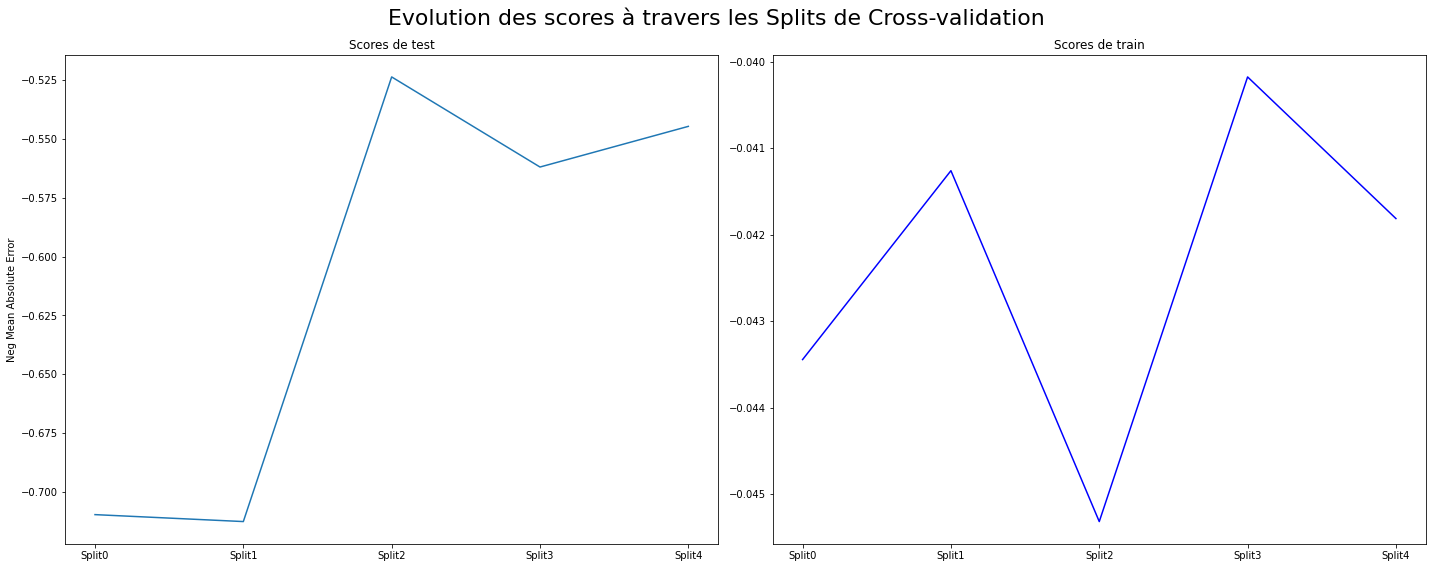

In [93]:
x = np.arange(0,5,1)
fig, ax = plt.subplots(1,2, figsize=(20,8), sharey=False, sharex=False)
ax[0].plot(range(0,5), Emissions_test_results.reshape(-1))
ax[0].set_xticks(x)
ax[0].set_xticklabels(["Split"+str(n) for n in range(0,5)])
ax[0].set_ylabel('Neg Mean Absolute Error')
ax[0].set_title('Scores de test')

ax[1].plot(range(0,5), Emissions_train_results.reshape(-1), color='b')
ax[1].set_xticks(x)
ax[1].set_xticklabels(["Split"+str(n) for n in range(0,5)])
ax[1].set_title('Scores de train')

plt.suptitle("Evolution des scores à travers les Splits de Cross-validation", fontsize=22)
fig.tight_layout()

plt.show()

On voit ici que les scores des différents splits de cross-validation, pour les meilleurs paramètres obtenus, évoluent correctement lors de l'entrainement et des test, tout en restant dans la même échelle.

Les écarts et mauvais résultats obtenus dépendent donc du faible nombre de données qui impactent le Train_Test_Split initial. Le modèle est correctement entrainé mais n'obtient pas de bon résultats sur le jeu de test 

## Final SiteEnergyUseWN

In [94]:
start_time = time.time()

SEU_pred = SEU_rfr_model.predict(X_test)

print("Temps d'execution de l'agorithme : {:.2} s.".format((time.time() - start_time)))

Temps d'execution de l'agorithme : 0.024 s.


In [95]:
#Calcul des métriques pour les émissions de CO2
SEUmetrics = metrics_model(Y_test['SiteEnergyUseWN(kBtu)'],SEU_pred)
SEUmetrics

,Métrique,Résultats
0,MAE,0.445837
1,R²,0.835516


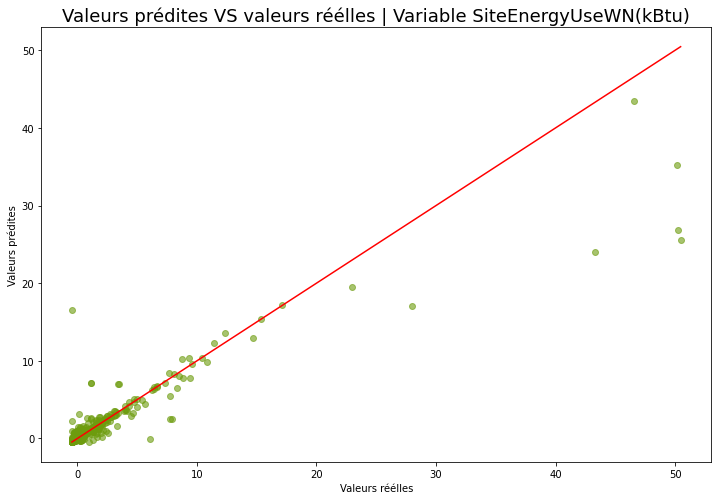

In [96]:
#Affichage des valeurs prédites vs valeurs réélles pour émissions de CO2
plot_pred_true(Y_test['SiteEnergyUseWN(kBtu)'],SEU_pred, color="#6D9C0E", title="SiteEnergyUseWN(kBtu)")

Le même problème que pour la variable TotalGHGEmissions se pose, malgrés de meilleurs résultats

## influence de l'energyStar

In [97]:
#Ajout de la variable à nos variables X
X['energystar_score'] = result_EnergyStar
#Ajout de la variable dans les variables numérique du preprocessor
#result_EnergyStar.append('energystar_score')

In [98]:
#Filtrage des données ayant un Energy Star Score renseigné
X = X[X['energystar_score'].isnull()==False]
Y = Y[Y.index.isin(list(X.index))]

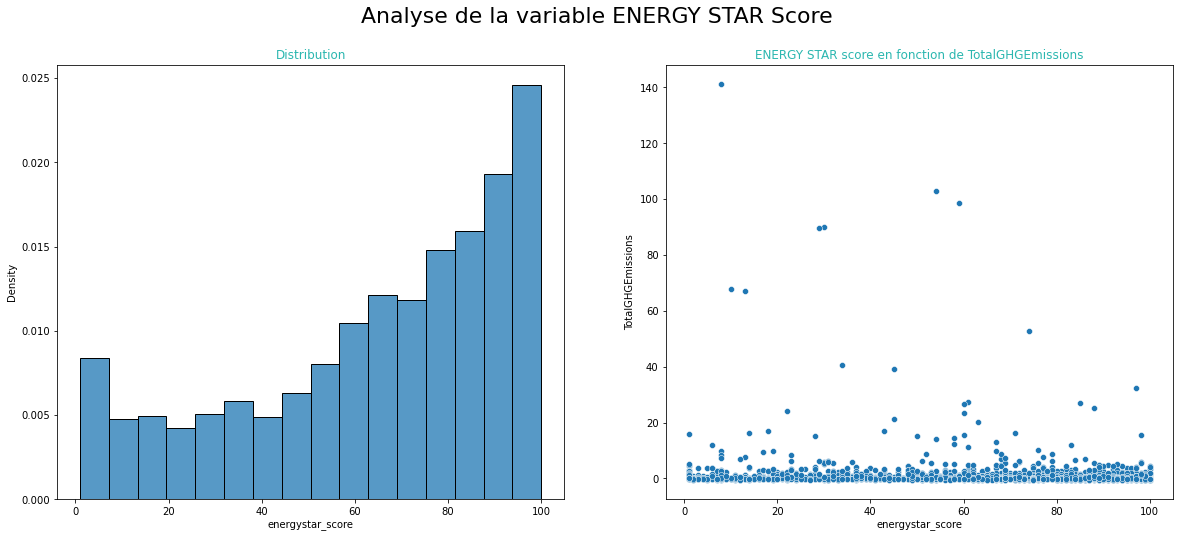

In [99]:
fig, axes = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=False, figsize=(20,8))
sns.histplot(data=X, x='energystar_score', stat="density", ax=axes[0])
axes[0].set_title("Distribution", color='#2cb7b0')
sns.scatterplot(data=pd.concat([X,Y], axis=1), y='TotalGHGEmissions', x='energystar_score', ax=axes[1])
axes[1].set_title("ENERGY STAR score en fonction de TotalGHGEmissions", color='#2cb7b0')
plt.suptitle("Analyse de la variable ENERGY STAR Score", fontsize=22)
plt.show()

De nombreux batiments sont au dessus de 60 en energyStar ce qui indique que ces batiments sont bien classés( donc un faible taux), en emissions de CO2.

In [52]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

print("Entrainement: {} lignes,\nTest: {} lignes.\n".format(X_train.shape[0],
                                                            X_test.shape[0]))

Entrainement: 1767 lignes,
Test: 442 lignes.



In [101]:
param_rfr = {'max_features' : ['sqrt', 'log2'],
             'max_depth': [15, 25, 50, 100], # Nombre de profondeurs maximums
             'min_samples_split': [2, 5, 10],
             'bootstrap' : [True, False],
             'min_samples_leaf': [1,2,5,10]}

rfr_grid_cv = Pipeline([
    ('grid_search_rfr', GridSearchCV(
                            RandomForestRegressor(), 
                            param_grid=param_rfr,
                            cv=kf,
                            scoring=('r2','neg_mean_absolute_error'),
                            refit='neg_mean_absolute_error',
                            return_train_score = True,
                            n_jobs = -1))])

GHG_rfr_model_eStar = rfr_grid_cv.fit(X_train, Y_train['TotalGHGEmissions'])
GHG_rfr_results_eStar = model_scores(GHG_rfr_model_eStar, 'grid_search_rfr')

Meilleur score MAE : -0.629
Meilleur Score R2 : 0.514
Meilleurs paramètres : {'bootstrap': False, 'max_depth': 50, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2}
Temps moyen d'entrainement : 1338.87s


In [102]:
GHG_pred_star = GHG_rfr_model_eStar.predict(X_test)
#Calcul des métriques pour les émissions de CO2
GHGmetricsES = metrics_model(Y_test['TotalGHGEmissions'],GHG_pred_star)
GHGmetrics = GHGmetrics.rename(columns={"Résultats" : "Sans ENERGY STAR"})
GHGmetrics['Avec ENERGY STAR'] = GHGmetricsES['Résultats']
GHGmetrics

,Métrique,Sans ENERGY STAR,Avec ENERGY STAR
0,MAE,1.272185,0.734729
1,R²,0.489218,0.725581


Le résultat du R² reste encore faible. On peut voir une amélioration du à l'EnergyStar, mais en raison du manque de données, il est difficile a dire si cette amlérioration est significative.